In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## First Look of the data

In [2]:

titanic_data = pd.read_csv('../input/titanic/train.csv', index_col = 'PassengerId')
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's check how many records are incomplete 

In [3]:
titanic_data.dropna()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...
872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C


Only 183 records have completely valid fields.<br>
But we can get rid of some fields.

In [4]:
features = [ 'Survived', 'Pclass','Sex', 'Age','SibSp', 'Parch','Fare', 'Embarked']
# features = [ 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


titanic_data_filtered = titanic_data[ features ].dropna()
titanic_data_filtered

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,3,female,39.0,0,5,29.1250,Q
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S


After some experimeting, it was found that removing fields like: name, Ticket and cabin, we can get a lot of records to train our ML model.

### Exploratory Data Analysis

In [5]:
titanic_data.groupby('Sex')['Survived'].mean()


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Almost 75% of the women survived, whereas only under 20% of the men survived.

In [6]:
titanic_data.groupby('Pclass')['Survived'].mean()


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

The data also shows that survival rate also depended on the classes,<br>
Upper: 62.9%,
Middle: 47.3%,
Lower: 24.2%

In [7]:
titanic_data.groupby(['Sex', 'Pclass'])['Survived'].mean().unstack()


Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


The data confirms our intuitions;<br> Nearly all of the first class women survived,<br>
whereas, only a little bit over 10% Third class men survived.

In [8]:
u18 = titanic_data[titanic_data['Age'] <= 18]['Survived'].mean()
o18 = titanic_data[titanic_data['Age'] > 18]['Survived'].mean()
age_surival_rate = pd.Series({'under_18':u18, 'over_18':o18}, name = 'Age_bracket_survival')
age_surival_rate.index.names = ['Age_bracket']
age_surival_rate


Age_bracket
under_18    0.503597
over_18     0.382609
Name: Age_bracket_survival, dtype: float64

In [9]:
age = pd.cut(titanic_data['Age'], [0, 18, 80])
titanic_data.groupby(['Sex', age, 'Pclass'])['Survived'].mean().unstack()

Pclass                  1         2         3
Sex    Age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [10]:
a = titanic_data.groupby(['Sex', age, 'Pclass'])['Survived'].mean().reset_index()
sex_class_age_survival = pd.Series(list(a['Survived']), index = a['Sex']+'_'+a['Pclass'].astype(str)+a['Age'].astype(str)).sort_values()

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'Survival Rate on Titanic based on Sex, Class and Age'}, xlabel='Category', ylabel='Survival Rate'>

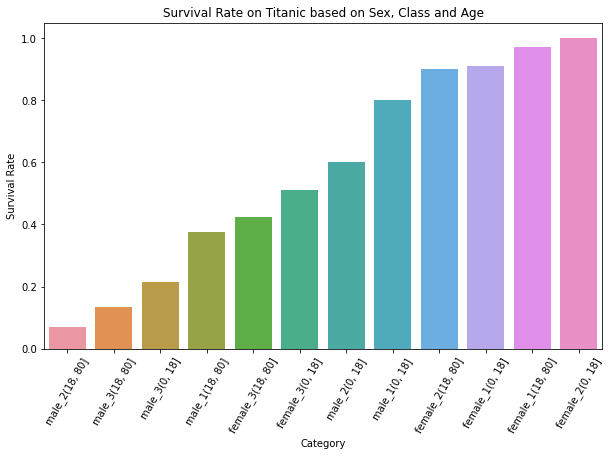

In [12]:
plt.figure(figsize = (10, 6))
plt.xticks(rotation = 60)
plt.xlabel('Category')
plt.ylabel('Survival Rate')
plt.title('Survival Rate on Titanic based on Sex, Class and Age')
sns.barplot(x = sex_class_age_survival.index, y = sex_class_age_survival.values)

### Checking out Survival rate with some other factors

In [13]:
titanic_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [14]:
price = pd.cut(titanic_data['Fare'],[0, 8, 15, 32,100, 200,300, 513])
titanic_data.groupby(price)['Survived'].aggregate(['mean', len])

,mean,len
Fare,,
"(0, 8]",0.225664,226
"(8, 15]",0.285714,217
"(15, 32]",0.459459,222
"(32, 100]",0.550633,158
"(100, 200]",0.757576,33
"(200, 300]",0.647059,17
"(300, 513]",1.000000,3


Let's see the fare cost based on sex and class

In [15]:
titanic_data.groupby(['Sex', 'Pclass'])['Fare'].mean().unstack()

Pclass,1,2,3
Sex,,,
female,106.125798,21.970121,16.118810
male,67.226127,19.741782,12.661633


So we discovered that the Fare for females was higher than for men

In [16]:
fare_bracket = pd.cut(titanic_data['Fare'],[0, 8, 15, 32, 513])
titanic_data.groupby(['Embarked', fare_bracket])['Survived'].aggregate([len, 'mean']).unstack()

len                                 mean                      \
Fare     (0, 8] (8, 15] (15, 32] (32, 513]    (0, 8]   (8, 15]  (15, 32]   
Embarked                                                                   
C            34      21       39        74  0.235294  0.428571  0.538462   
Q            51       6       18         2  0.392157  0.500000  0.333333   
S           141     190      165       133  0.163121  0.263158  0.454545   

                    
Fare     (32, 513]  
Embarked            
C         0.743243  
Q         0.500000  
S         0.511278

# Creating, Fitting and Predicting ML model

In [17]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error

In [18]:
modelling_features = [ 'Pclass','Sex', 'Age','SibSp', 'Parch','Fare', 'Embarked']

# Need to replace all the non-numerical data types with a number
# Replacing females with 0 and males with 1
titanic_data['Sex'].replace(['female','male'], [0,1],inplace=True)
# Replacing S, Q, C with 1, 2, 3
titanic_data['Embarked'].replace(['S','Q', 'C'], [1,2,3],inplace=True)

train_x = titanic_data[modelling_features].dropna()
train_y = titanic_data.filter(items = train_x.index, axis = 0)['Survived']


# Create and fit the model
titanic_model = RandomForestRegressor(random_state = 1)
titanic_model.fit(train_x, train_y)

RandomForestRegressor(random_state=1)

#### Model for those columns that have missing values

The test_data has some values - Cabin, Age and Fare

In [19]:
features_sin_age = [ 'Pclass','Sex', 'SibSp', 'Parch','Fare', 'Embarked']


train_x = titanic_data[features_sin_age].dropna()
train_y = titanic_data.filter(items = train_x.index, axis = 0)['Survived']



age_model = RandomForestRegressor(random_state=1)
age_model.fit(train_x, train_y)

RandomForestRegressor(random_state=1)

In [20]:
features_sin_fare = [ 'Pclass','Sex', 'SibSp', 'Parch','Age', 'Embarked']

train_x = titanic_data[features_sin_fare].dropna()
train_y = titanic_data.filter(items = train_x.index, axis = 0)['Survived']

fare_model = RandomForestRegressor(random_state=1)
fare_model.fit(train_x, train_y)

RandomForestRegressor(random_state=1)

In [21]:
features_sin_age_fare = [ 'Pclass','Sex', 'SibSp', 'Parch', 'Embarked']

train_x = titanic_data[features_sin_age_fare].dropna()
train_y = titanic_data.filter(items = train_x.index, axis = 0)['Survived']

age_fare_model = RandomForestRegressor(random_state=1)
age_fare_model.fit(train_x, train_y)

RandomForestRegressor(random_state=1)

## Performing predictions on the test data

In [22]:
test_data = pd.read_csv('../input/titanic/test.csv', index_col = 'PassengerId')

# Need to replace all the non-numerical data types with a number
# Replacing females with 0 and males with 1


test_data['Sex'].replace(['female','male'], [0,1],inplace=True)
# Replacing S, Q, C with 1, 2, 3
test_data['Embarked'].replace(['S','Q', 'C'], [1,2,3],inplace=True)


val_x = test_data[modelling_features].dropna()
predictions = titanic_model.predict(val_x)


In [23]:
# predicting for those with rows with only missing age
val_age_x = test_data[test_data['Age'].isnull()][features_sin_age].dropna()
age_predictions = age_model.predict(val_age_x)

In [24]:
# predicting for those with rows with only missing fare
val_fare_x = test_data[test_data['Fare'].isnull()][features_sin_fare].dropna()
fare_predictions = fare_model.predict(val_fare_x)

In [25]:
# predicting for those with missing both age and fare
val_age_fare_x = test_data[test_data['Age'].isnull() & test_data['Fare'].isnull()]
val_age_fare_x
# there are no rows with both Age and Fare missing

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,


In [26]:
indices = list(val_x.index)
indices.extend(list(val_age_x.index))
indices.extend(list(val_fare_x.index))
len(indices)

418

In [27]:
predictions_val = list(predictions)
predictions_val.extend(age_predictions)
predictions_val.extend(fare_predictions)
len(predictions_val)

418

In [28]:
# Since the predictions are in float, we need to set a chance threshold number
# over which the person would be considered to have survived
# surival_threshold of 0.6 resulted in a score of 0.76
# surival_threshold of 0.7 resulted in a score of 0.77
# surival_threshold of 0.75 resulted in a score of 0.77511
# surival_threshold of 0.8 resulted in a score of 0.7799
# surival_threshold of 0.85 resulted in a score of 0.767

survival_threshold = 0.8
test_predictions = list(map(lambda x: 1 if x>survival_threshold else 0, predictions_val))

In [29]:
sum(test_predictions)/len(test_predictions)

0.23923444976076555

In [30]:
res = pd.Series( test_predictions,indices, name = 'Survived')
res.index.names = ['PassengerId']

In [31]:
res

PassengerId
892     0
893     0
894     0
895     0
896     0
       ..
1302    0
1305    0
1308    0
1309    0
1044    0
Name: Survived, Length: 418, dtype: int64

In [32]:
output = pd.DataFrame({'PassengerId': indices, 'Survived': test_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [33]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1302,0
414,1305,0
415,1308,0
416,1309,0
